# Creating a Skincare Recommender

<img src="images/skincare_cover_photo.jpeg">

Image source: istockphoto.com

## Overview

This project explores skincare products from Sephora in order to build a recommendation system for consumers looking to find different products and develop a skincare routine suited for their needs. Additionally, the recommendations could be used for new users to Sephora who are looking for products based on their skin type and utilizing any past experiences with other skincare products. 

This notebook outlines the implementation of different techniques to build personalized recommendations including iterations to identify a model with low root-mean-square deviation (RMSE). From the dataset provided by Anastasia Gorina through [GitHub](.https://github.com/agorina91/final_project/blob/master/Jupyter_Notebook_and_CSV/skindataall.csv), user and product data from specific categories of skincare were examined. Additional resources that I found helpful and used for reference will be linked at the end of this notebook.

## Business Understanding

As one of largest cosmetics retailer, Sephora is hoping to find new ways to attract and interact with customers who might find skincare and the number of products out there overwhelming. Specifically, Sephora hopes to take into account past experiences of customers and are hoping to better filter products to suit new customers' needs.

From both the business and consumer perspectives, it will be beneficial to continually gather/keep track of customer ratings to improve the shopping experience and experiences with using certain products. This will help Sephora understand what customers like and what products may attract more customers. With this initial project, Sephora can gain insight on how to improve the shopping experience for new customers and build an even more sophisticated recommendation system. 

## Data Understanding/Preparation

As previously mentioned, I was able to find a dataset via GitHub. This data is suitable for this project because it contains a good number of entries and contains features that I feel are important in this initial recommendation system (ratings, user features, etc.). I hope to later scrape more and newer data to add to this iteration. For now, based on their project notes, the data was obtained through webscraping Sephora using selenium. The two resulting dataframes were combined and cleaned. It contains user and product data joined by unique user ID. Only four skincare categories are present in the dataset, however, there are over 8000 entries. After importing the neccessary libraries and reading in the data, I do some additional cleaning and exploratory analysis. Later on, the dataset will be split to training and testing sets for model validation.

In [1]:
#imports
import numpy as np
import pandas as pd
import random as rn
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from os import path
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator

from surprise import Dataset, Reader
from surprise.model_selection import train_test_split, cross_validate
from surprise.prediction_algorithms import SVD
from surprise.prediction_algorithms import knns
from surprise.model_selection import GridSearchCV
from surprise.similarities import cosine, msd, pearson
from surprise import accuracy

In [2]:
df = pd.read_csv('skindataall.csv', index_col=[0])

In [3]:
df.head()

,Username,Skin_Tone,Skin_Type,Eye_Color,Hair_Color,Rating_Stars,Review,Product,Brand,Price,...,Oily,Sensitive,Category,Product_Url,User_id,Product_id,Ingredients_Cleaned,Review_Cleaned,Good_Stuff,Ing_Tfidf
0,allyp3,Medium,Combination,Brown,Brunette,5,This is hands down the best cleanser I’ve ever...,Superfood Antioxidant Cleanser,YOUTH TO THE PEOPLE,36,...,0,0,Cleanser,https://www.sephora.com/product/kale-spinach-g...,3420,157,"['sodium', 'cocoyl', 'glutamate', 'cocamidopro...","['hand', 'best', 'cleanser', 'ever', 'used', '...",1,"sodium, cocoyl, glutamate, cocamidopropyl, bet..."
1,PatTea,Medium,Combination,Brown,Red,1,Unfortunately this doesn’t work for everyone. ...,Superfood Antioxidant Cleanser,YOUTH TO THE PEOPLE,36,...,0,0,Cleanser,https://www.sephora.com/product/kale-spinach-g...,2483,157,"['sodium', 'cocoyl', 'glutamate', 'cocamidopro...","['unfortunately', 'work', 'everyone', 'used', ...",0,"sodium, cocoyl, glutamate, cocamidopropyl, bet..."
2,Sabi1991,No data,No data,No data,No data,5,My favorite cleanser!! i love the packaging on...,Superfood Antioxidant Cleanser,YOUTH TO THE PEOPLE,36,...,0,0,Cleanser,https://www.sephora.com/product/kale-spinach-g...,2715,157,"['sodium', 'cocoyl', 'glutamate', 'cocamidopro...","['favorite', 'cleanser', 'love', 'packaging', ...",1,"sodium, cocoyl, glutamate, cocamidopropyl, bet..."
3,happyface2,Fair,Dry,Blue,Blonde,5,I love all things Youth To The People! This cl...,Superfood Antioxidant Cleanser,YOUTH TO THE PEOPLE,36,...,0,0,Cleanser,https://www.sephora.com/product/kale-spinach-g...,4497,157,"['sodium', 'cocoyl', 'glutamate', 'cocamidopro...","['love', 'thing', 'youth', 'people', 'cleanser...",1,"sodium, cocoyl, glutamate, cocamidopropyl, bet..."
4,kimkix34,Fair,Normal,Green,Blonde,5,I had a trial size of this and was obsessed. M...,Superfood Antioxidant Cleanser,YOUTH TO THE PEOPLE,36,...,0,0,Cleanser,https://www.sephora.com/product/kale-spinach-g...,5017,157,"['sodium', 'cocoyl', 'glutamate', 'cocamidopro...","['trial', 'size', 'wa', 'obsessed', 'skin', 'f...",1,"sodium, cocoyl, glutamate, cocamidopropyl, bet..."


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8649 entries, 0 to 8702
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Username             8649 non-null   object 
 1   Skin_Tone            8649 non-null   object 
 2   Skin_Type            8649 non-null   object 
 3   Eye_Color            8649 non-null   object 
 4   Hair_Color           8649 non-null   object 
 5   Rating_Stars         8649 non-null   int64  
 6   Review               8649 non-null   object 
 7   Product              8649 non-null   object 
 8   Brand                8649 non-null   object 
 9   Price                8649 non-null   int64  
 10  Rating               8649 non-null   float64
 11  Ingredients          8649 non-null   object 
 12  Combination          8649 non-null   int64  
 13  Dry                  8649 non-null   int64  
 14  Normal               8649 non-null   int64  
 15  Oily                 8649 non-null   i

As you can see, there are various columns in this dataframe. It contains a mix of strings and integers, below I've include a brief description of each feature.

- Username: username of the user who left a review for the specific product
- Skin_Tone: indicated skin color of the user
- Skin_Type: indicated skin type of the user
- Eye_Color: indicated eye color of the user
- Hair_Color: indicated hair color of the user
- Rating_Stars: selected rating that the user gave for the product on a scale of 1-5 stars
- Review: text of the review left by the user
- Product: name of the product
- Brand: brand name of the product
- Price: how much the product costs
- Rating: average rating of the product
- Ingredients: list of ingredients in the product
- Combination, Dry, Normal, Oily, Sensitive: One-hot encoded columns for skin type that the product targets
- Category: what type of product it's labeled as
- Product_Url: link to the product webpage
- User_id: unique id number of user
- Product_id: unique id number of product
- Ingredients_Cleaned: list of ingredients in the product, but cleaned and broken into list for each ingredient rather than a long block of text found in original Ingredients column
- Review_Cleaned: similar to Ingredients_Cleaned; cleaned text of the review from original Review column
- Good_Stuff: 1 or 0 for yes or no, indicator on Sephora's product pages for ingredients considered good/clean
- Ing_Tfidf: a more clean and simplified ingredient list of product, after considering how important specific words are to the set

In [5]:
#checking that all categories of products are what I'm interested in
df['Category'].unique()

array(['Cleanser', 'Moisturizer', 'Face Mask', 'Treatment'], dtype=object)

After ensuring that the categories in the dataset are relevant to skincare, the dataset looks fairly clean otherwise. All the labels are relevant to face skincare products with no missing values. I'm going to explore further if there are any repeats and what the distribution of the features are.

In [7]:
#seeing distribution of continuous features
df[['Price', 'Rating_Stars', 'Rating']].describe()

,Price,Rating_Stars,Rating
count,8649.000000,8649.000000,8649.000000
mean,47.289860,4.101861,4.290982
std,35.774619,1.362036,0.470872
min,4.000000,1.000000,0.000000
25%,28.000000,3.000000,4.200000
50%,38.000000,5.000000,4.400000
75%,58.000000,5.000000,4.500000
max,370.000000,5.000000,5.000000


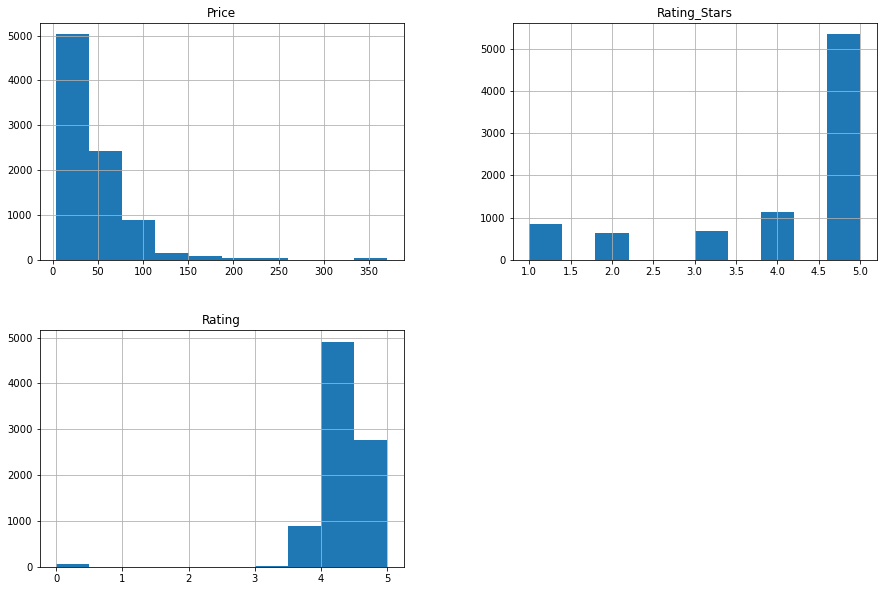

In [8]:
#histograms of continuous features
df[['Price', 'Rating_Stars', 'Rating']].hist(figsize=[15,10]);

In [9]:
#how many different brands are there
df['Brand'].describe()

count         8649
unique          60
top       CLINIQUE
freq           685
Name: Brand, dtype: object

It appears that the majority of the products are less than $100, which could be beneficial for consumers looking for more affordable options. For Rating Stars, which is the rating a consumer gives a product on a scale of 1-5 stars shows people usually leaves reviews and ratings when they are satisfied with the product. This also relates to average ratings of products being predominately greater than 4. The dataset also includes a fairly diverse set of various brands. Sephora is known for having a wide variety, so this can be benefical in recommending different products. The top brand in this dataset appears to be Clinique, appearing over 600 times. 

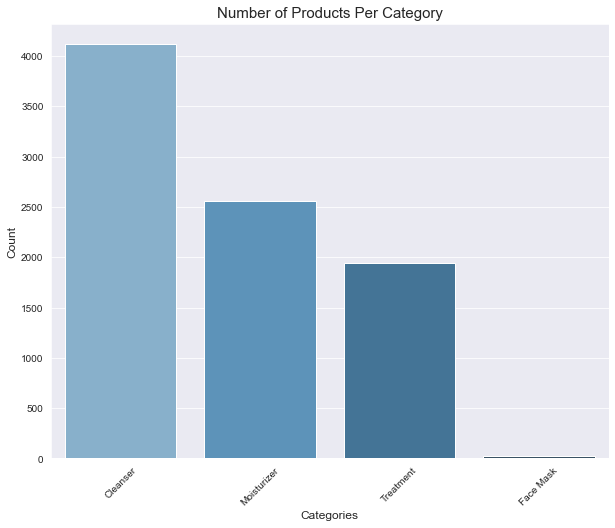

In [10]:
#distribution of different types of products
plt.figure(figsize=(10, 8))
sns.set_style('darkgrid')

plot = sns.countplot(data=df,
                     x='Category',
                     palette='Blues_d',
                     order=df.Category.value_counts().index)

plt.setp(plot.get_xticklabels(), rotation=45)
plt.xlabel('Categories', size=12)
plt.ylabel('Count', size=12)
plt.title('Number of Products Per Category', size=15)
plt.show()

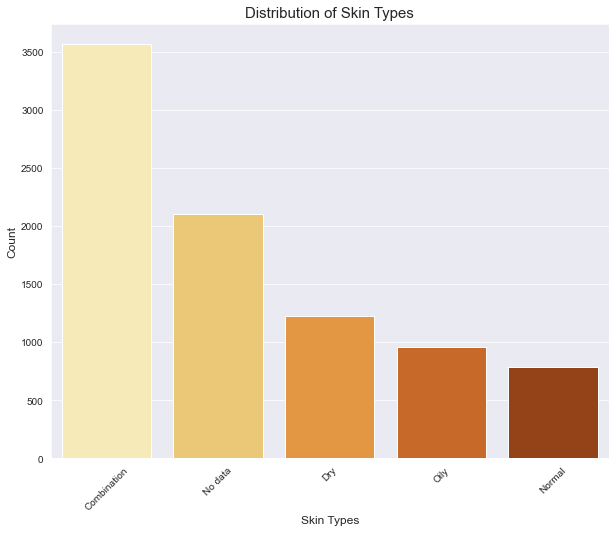

In [11]:
#distribution of skin types
plt.figure(figsize=(10, 8))
sns.set_style('darkgrid')

plot = sns.countplot(data=df,
                     x='Skin_Type',
                     palette='YlOrBr',
                     order=df.Skin_Type.value_counts().index)

plt.setp(plot.get_xticklabels(), rotation=45)
plt.xlabel('Skin Types', size=12)
plt.ylabel('Count', size=12)
plt.title('Distribution of Skin Types', size=15)
plt.show()

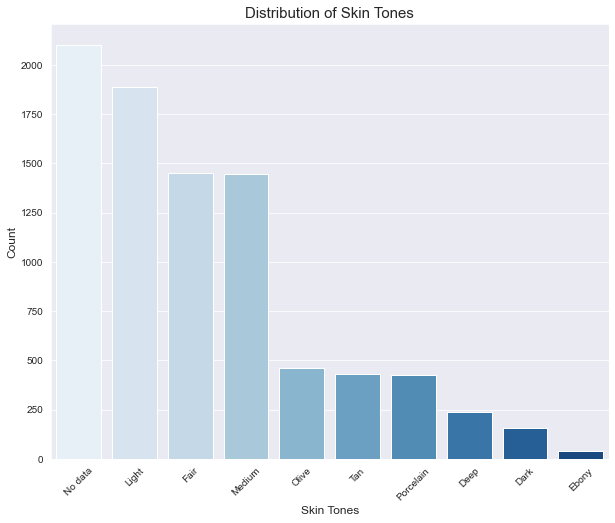

In [4]:
#distribution of skin tone
plt.figure(figsize=(10, 8))
sns.set_style('darkgrid')

plot = sns.countplot(data=df,
                     x='Skin_Tone',
                     palette='Blues',
                     order=df.Skin_Tone.value_counts().index)

plt.setp(plot.get_xticklabels(), rotation=45)
plt.xlabel('Skin Tones', size=12)
plt.ylabel('Count', size=12)
plt.title('Distribution of Skin Tones', size=15)
plt.show()

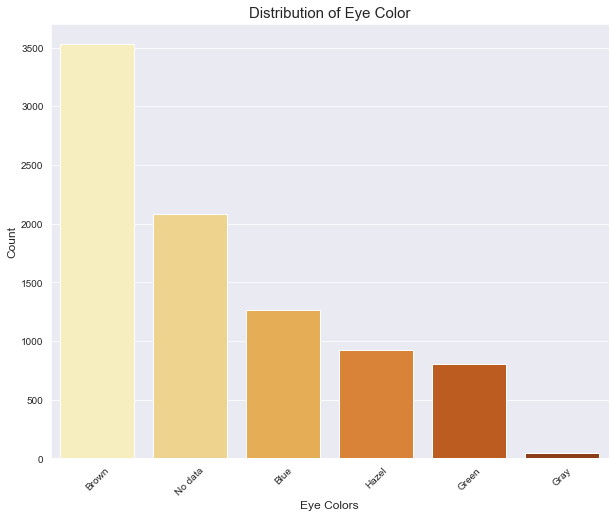

In [9]:
#distribution of eye color
plt.figure(figsize=(10, 8))
sns.set_style('darkgrid')

plot = sns.countplot(data=df,
                     x='Eye_Color',
                     palette='YlOrBr',
                     order=df.Eye_Color.value_counts().index)

plt.setp(plot.get_xticklabels(), rotation=45)
plt.xlabel('Eye Colors', size=12)
plt.ylabel('Count', size=12)
plt.title('Distribution of Eye Color', size=15)
plt.show()

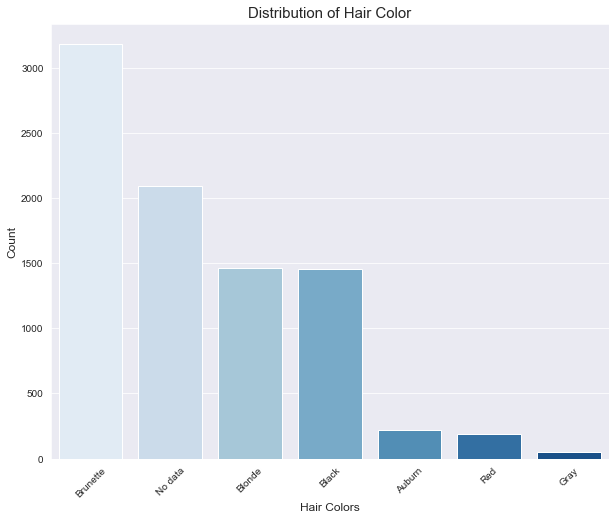

In [10]:
#distribution of hair color
plt.figure(figsize=(10, 8))
sns.set_style('darkgrid')

plot = sns.countplot(data=df,
                     x='Hair_Color',
                     palette='Blues',
                     order=df.Hair_Color.value_counts().index)

plt.setp(plot.get_xticklabels(), rotation=45)
plt.xlabel('Hair Colors', size=12)
plt.ylabel('Count', size=12)
plt.title('Distribution of Hair Color', size=15)
plt.show()

There is quite a majority of products classified as cleansers within the dataset. By briefly looking over the dataset and with some domain knowledge, I know many products which might be toners or makeup removers can still be used and classified as cleaners. This might be fine for some customers who receive these recommendations, but might not for others. For now, this is a caveat I'll have to keep in mind. Hopefully, in future iterations, we can better filter these products that might fall under multiple categories.

In terms of the distributions of the users, there are about 2000 entries that did not indicate skin type, skin tone, hair and eye color. This might make it more difficult to accurately recommend products based on user features, but it is common to have missing data if it's not a required input. Finding recommendations based on multiple different features and/or how similar rated products are probably the best approaches.

## Modeling

As mentioned, a recommendation system will help customers find products. There are two main types: unpersonalized and personalized. For this project, I focus on personalized recommendations. Currently, on the Sephora landing page, there are carousals of products that "Just Dropped", "Selling Fast", "Chosen For You" (which probably is linked to the specific consumer's account such as purchase and browsing history). For new customers, a more personalized shopping experience can be beneficial too. 

This is where the different techniques of collaborative filtering comes in. The different approaches will be explored in this modeling section. Through the different models, RMSE is examined to maintain a consistent way of evaluating how well each model performs on the test dataset.

### Collaborative Filtering

For this project, I decided to focus on collaborative filtering, which is a popular technique for personalized recommendation systems. Other common recommendation systems are content-based recommenders. For example, content-based recommenders are currently seen on each Sephora product page and on the home landing page as well. This is seen as "Similar Products" or "You May Also Like". The main idea for content-based recommenders are if the user likes an item, they will also like similar items. Even though this type of recommender allows users to see a bit more information as to why they are recommended these similar products, content-based recommenders often require more manual tagging/analysis of each product. 

Collaborative filtering systems, on the other hand, uses a collection of user ratings to make recommendations. Rather than comparing similar products, it compares users that have may have similar ratings/preferences to similar items. An issue that can arise is making recommendations based off of user activity when there might not be any if the user is new. Although there is not a perfect approach, I iterate through a few between memory-based and model-based approaches using the python libraries surprise and pyspark.

#### Memory-Based Approach

KNNBasic vs. KNNMeans vs. KNNBaseline

First, I will explore Memory-Based methods of building recommendations, also known as neighborhood-based. This essentially uses user rating historical data to compute similarity between users or items. More specifically, this method attempts to quantify how similar users and items are to one another and then getting the top N recommendations based on a similarity metric. This is captured by the use of a utility matrix either with explicit or implicit data.

In [11]:
#loading in the dataset with surprise's built-in reader 
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['User_id', 'Product_id', 'Rating_Stars']], reader)
type(data)

surprise.dataset.DatasetAutoFolds

In [12]:
#split into train and test set
train, test = train_test_split(data, test_size=0.2)

In [13]:
#check number of users vs. items in train set
print('Number of users: ', train.n_users, '\n')
print('Number of items: ', train.n_items, '\n')

Number of users:  5695 

Number of items:  315 



The only features used are ratings of users and items and we want to keep them together; therefore, there is no X_train and y_train. The dataset is split, with 20% in the test set. After exploring the number of users vs. item in the train set, there are more users than items. This means for computational efficiency, it makes more sense to calculate item-item similarity since it's best to calculate the similarity between whichever is fewer. Item-based similarity measures the similarity between the items that target users rates with and other items. Now that I've landed on utilizing item-based filtering, I iterate through KNN algorithms to compare similarity metrics and RMSE.

In [14]:
#knn basic w/ cosine
sim_cos = {'name': 'cosine', 'user_based': False}
#train/fit model
basic = knns.KNNBasic(sim_options=sim_cos)
basic.fit(train)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [15]:
#test model to see how it performed
predictions = basic.test(test)
print(accuracy.rmse(predictions))

RMSE: 1.2289
1.2289202102228867


This model had an RMSE of about 1.23, which means it was roughly a bit over 1 point off for each guess in ratings. Although, this is not bad, the scale of ratings for products is only on a scale of 1-5, so a difference of a point or more can be a big difference for someone. After trying cosine similarity, potentially utilizing a different similarity metric (pearson) could improve the model.

In [16]:
#knn basic w/ pearson
sim_pearson = {'name': 'pearson', 'user_based': False}
basic_2 = knns.KNNBasic(sim_options=sim_pearson)
basic_2.fit(train)
predictions = basic_2.test(test)
print(accuracy.rmse(predictions))

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.2047
1.2047076818724796


There was a slight better performance with pearson correlation, so I will use this similarity metric for future iterations. Next, I will compare the performances of KNN with Means and KNN Baseline. KNN with Means is similar to the basic KNN, however, it takes into account the mean rating of each item. KNN Baseline a more advanced method that adds a bias term by incorporating a cost function.

In [17]:
#knn with means w/ pearson
sim_pearson = {'name': 'pearson', 'user_based': False}
knn_means = knns.KNNWithMeans(sim_options=sim_pearson)
knn_means.fit(train)
predictions = knn_means.test(test)
print(accuracy.rmse(predictions))

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.2088
1.2088087878099327


In [18]:
#knnbaseline w/ pearson
sim_pearson = {'name': 'pearson', 'user_based': False}
knn_baseline = knns.KNNBaseline(sim_options=sim_pearson)
knn_baseline.fit(train)
predictions = knn_baseline.test(test)
print(accuracy.rmse(predictions))

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1744
1.1743808062026764


In [19]:
#cross-validating with KNNBaseline
cv_knn_baseline = cross_validate(knn_baseline, data)

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.


In [20]:
#print average score for test set
for i in cv_knn_baseline.items():
    print(i)
    
np.mean(cv_knn_baseline['test_rmse'])

('test_rmse', array([1.19513706, 1.14826683, 1.229157  , 1.22305443, 1.19390427]))
('test_mae', array([0.8551192 , 0.83340147, 0.88871456, 0.86789046, 0.87065451]))
('fit_time', (0.025097131729125977, 0.023626089096069336, 0.018824100494384766, 0.020615100860595703, 0.02809596061706543))
('test_time', (0.027277708053588867, 0.010239124298095703, 0.009793996810913086, 0.009446859359741211, 0.012626171112060547))


1.1979039163192748

The KNNBaseline method ended up with the lowest RMSE (1.17) when utilizing pearson correlation. After cross-validating, it does appear consistent to perform with RMSE of less than 1.2, which is better than the other KNN models. However, the downside to using memory-based methods is that the whole input data is needed and isn't as scale-able when compared to model-based methods. In the next section, I explore model-based techniques.

#### Model-Based Approach

SVD vs. ALS

Also known as matrix factorization, model-based filtering is based on Latent Variable Models. This attempts to explain relationships between variables by exploring their relationships and latent variables (unobservable variables). This is useful when datasets are sparse because typically users don't buy and rate all items. 

I will implement two different techniques. The surprise library has Singular Value Decomposition (SVD) implemented, which makes it easy to use. The other technique is called Alternating Least Squares (ALS), which can potentially be more effective and robust than SVD. Spark has a library, ml, that implements ALS.

In [21]:
#initial SVD w/ default parameters
svd = SVD()
svd.fit(train)

predictions = svd.test(test)
print(accuracy.rmse(predictions))

RMSE: 1.2406
1.2405753168553455


In [22]:
#finding best params for SVD with grid search
params = {
    'n_factors': [10, 50, 100, 200, 500], #number of factors
    'n_epochs': [5, 10, 20, 50, 100], #number of iteration of SGD procedures
    'lr_all': [0.005, 0.01, 0.1], #learning rate for all params
    'reg_all': [0.02, 0.4, 0.6] #regularization term for all params
}

gs_svd = GridSearchCV(SVD, param_grid=params, n_jobs=-1, joblib_verbose=5)
gs_svd.fit(data)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done 616 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done 850 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1125 out of 1125 | elapsed:  4.1min finished


In [23]:
#print best params
print(gs_svd.best_params['rmse'])

{'n_factors': 500, 'n_epochs': 100, 'lr_all': 0.1, 'reg_all': 0.02}


In [24]:
#fit and test SVD w/ best params
svd_2 = SVD(n_factors=500, n_epochs=100, lr_all=0.1, reg_all=0.02)
svd_2.fit(train)

predictions = svd_2.test(test)
print(accuracy.rmse(predictions))

RMSE: 1.1765
1.1764818901013963


Prior to the gridsearch, the SVD model had an RMSE of about 1.24. After adjusting the parameters, the performance improved slightly with an RMSE of about 1.18. This is very similar to the KNN Baseline RMSE. Next, I'll explore ALS to finish off this modeling section.

In [25]:
#import neccessary library for Spark
from pyspark.sql import SparkSession
#instantiate SparkSession object
spark = SparkSession\
        .builder\
        .appName('ALSModel').config('spark.driver.host', 'localhost')\
        .getOrCreate()

In [26]:
#load in dataset into pyspark dataframe
py_data = spark.read.csv('skindataall.csv', header='true', inferSchema='true')

In [27]:
#checking data types of columns
py_data = py_data.select('User_id', 'Product_id', 'Rating_Stars')

In [28]:
py_data.dtypes

[('User_id', 'string'), ('Product_id', 'string'), ('Rating_Stars', 'string')]

In [29]:
#updating to the correct data types 
from pyspark.sql.types import ShortType, ByteType

py_data = py_data.withColumn('User_id', py_data['User_id'].cast(ShortType()))
py_data = py_data.withColumn('Product_id', py_data['Product_id'].cast(ShortType()))
py_data = py_data.withColumn('Rating_Stars', py_data['Rating_Stars'].cast(ByteType()))

In [30]:
py_data.dtypes

[('User_id', 'smallint'),
 ('Product_id', 'smallint'),
 ('Rating_Stars', 'tinyint')]

In [31]:
#checking for nulls
py_data.filter("User_id is NULL").show()

+-------+----------+------------+
|User_id|Product_id|Rating_Stars|
+-------+----------+------------+
|   null|      null|           5|
|   null|      null|           0|
|   null|      null|           1|
|   null|      null|           0|
|   null|      null|           5|
|   null|      null|           0|
|   null|      null|           5|
|   null|      null|           0|
|   null|      null|           5|
|   null|      null|           0|
|   null|      null|           3|
|   null|      null|           0|
|   null|      null|           5|
|   null|      null|           0|
|   null|      null|           1|
|   null|      null|           0|
|   null|      null|           5|
|   null|      null|           0|
|   null|      null|           5|
|   null|      null|           0|
+-------+----------+------------+
only showing top 20 rows



In [32]:
#fill nulls w/ correct value
py_data = py_data.na.fill(value=0)

In [33]:
#import ALS module
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
#split dataframe into train and test sets
(train, test) = py_data.randomSplit([0.8, 0.2])

In [34]:
#fit ALS to train set after selecting appropriate columns
#set cold start strategy to 'drop' to avoid getting NaN evaluation metrics
als = ALS(maxIter=5,
          rank=4,
          regParam=0.01,
          userCol='User_id',
          itemCol='Product_id',
          ratingCol='Rating_Stars',
          coldStartStrategy='drop')

als_model = als.fit(train)

In [35]:
#import RegressionEvaluator to evaluate model
from pyspark.ml.evaluation import RegressionEvaluator
#compute RMSE on test data
predictions = als_model.transform(test)
evaluator = RegressionEvaluator(metricName='rmse',
                                labelCol='Rating_Stars',
                                predictionCol='prediction')

rmse = evaluator.evaluate(predictions)
print('RMSE: ' + str(rmse))

RMSE: 2.456991355662732


After the fitting the initial ALS model, it performs worse than the other models. An RMSE of 2.46 is quite high and not ideal when our rating scale is between 1-5, being off by over 2 points is a big difference.

In [36]:
#cross validate to find best params for ALS 
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
#initialize new ALS model
als_model2 = ALS(userCol='User_id',
                itemCol='Product_id',
                ratingCol='Rating_Stars',
                coldStartStrategy='drop')
#create parameter grid
params = ParamGridBuilder()\
            .addGrid(als_model2.regParam, [0.01, 0.001, 0.1])\
            .addGrid(als_model2.rank, [4, 10, 50]).build()
#instantiate crossvalidator estimator
cv = CrossValidator(estimator=als_model2, 
                    estimatorParamMaps=params, 
                    evaluator=evaluator, 
                    parallelism=4)
#find best model rank
best_als = cv.fit(py_data)
best_als.bestModel.rank

50

In [37]:
#fit new ALS model with best rank param from cross-validation
als_cv = ALS(maxIter=5,
             rank=50,
             regParam=0.01,
             userCol='User_id',
             itemCol='Product_id',
             ratingCol='Rating_Stars',
             coldStartStrategy='drop')

als_model2 = als_cv.fit(train)

predictions = als_model2.transform(test)
evaluator = RegressionEvaluator(metricName='rmse',
                                labelCol='Rating_Stars',
                                predictionCol='prediction')

rmse = evaluator.evaluate(predictions)
print('RMSE: ' + str(rmse))

RMSE: 2.129455340654802


After tuning the ALS model slightly, RMSE only approved slightly and is still about 1 point worse than the KNN Baseline and SVD.

### Recommender Based on Customer Features

To start, it is quite straightforward to filter the products and recommend top-rated products based on an input of features, such as the customer's skin type and what type of product they are looking for. This can then be built upon to include other features that customers might like to consider.

In [38]:
def rec_by_user_needs(skin_type, cat_type, percentile=0.9):
    ddf = df[(df['Skin_Type']==skin_type) & (df['Category'] ==cat_type)]
    
    recs = ddf[['Rating', 'Product', 'Brand', 'Price', 'Product_Url']]
    recs = recs.sort_values('Rating', ascending=False).drop_duplicates().head()
    
    print('Here are your top 5 recommendations:')
    return recs

In [39]:
rec_by_user_needs('Dry', 'Cleanser')

Here are your top 5 recommendations:


,Rating,Product,Brand,Price,Product_Url
4786,5.0,Epidermal Re-Texturizing Micro-Dermabrasion,KIEHL'S SINCE 1851,41,https://www.sephora.com/product/epidermal-re-t...
6015,4.9,Multi-Miracle Glow Cleansing Balm,CHARLOTTE TILBURY,60,https://www.sephora.com/product/multi-miracle-...
600,4.9,Facial Cotton,SHISEIDO,10,https://www.sephora.com/product/facial-cotton-...
6392,4.9,Fresh Pressed Renewing Powder Cleanser with Pu...,CLINIQUE,29,https://www.sephora.com/product/fresh-pressed-...
5264,4.9,Exfoilating Wipes - Papaya - Glow,SEPHORA COLLECTION,7,https://www.sephora.com/product/exfoilating-wi...


To build off of this, we can use our models to further predict and make recommendations that are more specifically tailored to customer preferences. I'll build these recommendations based on KNN Baseline model, which had the lowest RMSE on test performance.

In [40]:
dataset = data.build_full_trainset()
print('Number of users: ', dataset.n_users, '\n')
print('Number of items: ', dataset.n_items)

Number of users:  6851 

Number of items:  315


In [41]:
#simple predictions with KNNBaseline
knn_baseline.fit(dataset)

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.


In [42]:
knn_baseline.predict(2, 4)

Prediction(uid=2, iid=4, r_ui=None, est=3.8179128371211366, details={'actual_k': 0, 'was_impossible': False})

It's nice to make simple predictions based on this model; however, it would be more beneficial to get specific products based on the customer's preferences. This function will obtain customer ratings from randomly selected products, take into account these preferences and give a list of products that is also based on the specific category and skin type that customers indicate.

In [43]:
def skincare_rec(num, product_df, category=None, skin_type=None):
    raw_userid = input('Enter ID: ')
    rating_list = []
    #filter df based on skin type/category and get new ratings
    while num > 0:
        if skin_type:
            product_df = product_df[product_df[skin_type] == 1]
        else:
            product_df = product_df
        if category:
            product_df = product_df[product_df['Category'] == category]
            product = product_df.sample(1)
        else:
            product = product_df.sample(1)
        print(product[['Product', 'Brand', 'Price', 'Product_Url']])
        rating = input(
            'How do you rate this product on a scale of 1-5, press n if you have not used this before:\n'
        )
        if rating == 'n':
            continue
        else:
            rating_one_product = {
                'User_id': raw_userid,
                'Product_id': product['Product_id'].values[0],
                'Rating_Stars': rating
            }
            rating_list.append(rating_one_product)
            num -= 1

    #add the new ratings to the original df
    new_ratings_df = product_df[['User_id', 'Product_id',
                                 'Rating_Stars']].append(rating_list,
                                                         ignore_index=True)
    new_data = Dataset.load_from_df(new_ratings_df, reader)
    #train model on the new combined df
    knn_baseline = knns.KNNBaseline(sim_options={
        'name': 'pearson',
        'user_based': False
    })
    knn_baseline.fit(new_data.build_full_trainset())
    #make predictions for the customer; order the predictions from high to low
    list_of_prods = []
    for prod_id in product_df['Product_id'].unique():
        list_of_prods.append(
            (prod_id, knn_baseline.predict(raw_userid, prod_id)[3]))
    ranked_prods = sorted(list_of_prods, key=lambda x: x[1], reverse=True)
    #return the top n recommendations
    num_prods = int(
        input('How many products would you like to be recommended to you?\n'))
    for idx, rec in enumerate(ranked_prods):
        name = product_df.loc[product_df['Product_id'] == int(
            rec[0])]['Product']
        print('Recommendation #', idx + 1, ': ', name.drop_duplicates(), '\n')
        num_prods -= 1
        if num_prods == 0:
            break

As seen above, the skincare_rec function is able to take in input from customers, such as skin type and product type. Upon rating products that they may have used in the past, the similarity matrix is calculated to find the desired number of recommended products most similar.

## Evaluation

I was able to successfully implement collaborative filtering models, between memory-based and model-based approaches, the KNN Baseline and SVD were the best performing in terms of low RMSE scores. Between these two approaches, I ultimately decided to use the KNN Baseline with pearson similarity since it was had a slightly lower RMSE. I've copied the mean test RMSE of the KNN Baseline below for easier reference. By having a lower RMSE, we're are decreasing the amount our predictions are off from actual ratings. Especially on Sephora's rating scale of 1-5, I found it important to have a low RMSE because the difference between a 3 and 4, can be substantial from a customer's perspective. However, in future iterations, SVD might be the better technique if and how the data differs and the project is scaled to accommodate more users/products. 

In [45]:
#average score for test set cross validation of KNN Baseline w/ pearson
for i in cv_knn_baseline.items():
    print(i)
    
np.mean(cv_knn_baseline['test_rmse'])

('test_rmse', array([1.19513706, 1.14826683, 1.229157  , 1.22305443, 1.19390427]))
('test_mae', array([0.8551192 , 0.83340147, 0.88871456, 0.86789046, 0.87065451]))
('fit_time', (0.025097131729125977, 0.023626089096069336, 0.018824100494384766, 0.020615100860595703, 0.02809596061706543))
('test_time', (0.027277708053588867, 0.010239124298095703, 0.009793996810913086, 0.009446859359741211, 0.012626171112060547))


1.1979039163192748

Upon iterating through the models, I incorporated the best model with the parameters to retrieve recommendations for a customer by adding new ratings and then giving a specified number of recommendations. 

This is able to not only recommend products, it is a tool that can help Sephora attract customers, and especially new customers, who want to be suggested specific products rather than spend time clicking through pages of products. This can be overwhelming and with a recommender, the online shopping experience can feel a bit more personal.

From this initial analysis, I was able to explore a portion of recommendation systems that can be beneficial for businesses like Sephora and help gather data that can be useful to know. It is important to recognize that recommendation systems are very dependent on the use case or in other words, the needs of the business and what type of information do we want to provide to users. Below the recommender function is tested and as you can see, is able to recommend a desired number of products based on the similarities calculated from a customer's inputs.

In [44]:
skincare_rec(2, df, 'Moisturizer', 'Oily')

Enter ID: 999
                                                Product    Brand  Price  \
2231  Dr. Andrew Weil For Origins™ Mega-Bright SPF 3...  ORIGINS     56   

                                            Product_Url  
2231  https://www.sephora.com/product/dr-andrew-weil...  
How do you rate this product on a scale of 1-5, press n if you have not used this before:
2
                  Product        Brand  Price  \
2636  Argan Cleansing Oil  JOSIE MARAN     32   

                                            Product_Url  
2636  https://www.sephora.com/product/argan-cleansin...  
How do you rate this product on a scale of 1-5, press n if you have not used this before:
4
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
How many products would you like to be recommended to you?
3
Recommendation # 1 :  3000    Vine[activ] Overnight Detox Oil
Name: Product, dtype: object 

Recommendation # 2 :  2520    Daily Reviving Concentrate
N

### Next Steps

Through this iterative process, a few things to be considered for future exploration:

- Obtaining more data on different products and users will allow the recommendation system to be scaled and become more sophisticated. Not only would there be more data to analyze, more products and different types of products could be recommended to customers.
- Including different categories of skincare in future iterations will also allow customers to find a diverse set of products rather than the core categories in this project so far.
- Two different approaches showcased similar performance results. Therefore, depending on the scale, one may be better suited than the other and should be considered when building out the web app.
- I'm currently building out a web app for model deployment and for users to interact with the recommendation system. The repository of this project will be updated upon completion.
- It would be interesting to explore different ways to recommend products, such as looking at ingredients and recommending products based on other products that customers like and have similar ingredients.


### Resources
- [Spark Documentation](https://spark.apache.org/docs/latest/sql-ref-datatypes.html#:~:text=The%20range%20of%20numbers%20is%20from%20%2D32768%20to%2032767%20.,8%2Dbyte%20signed%20integer%20numbers.)
- [Recommendation Systems - Models and Evaluation by Neerja Doshi](https://towardsdatascience.com/recommendation-systems-models-and-evaluation-84944a84fb8e)
- [Using Customer and Product Features in Recommender Systems by Tatev Karen](https://medium.com/mlearning-ai/using-customer-and-product-features-in-recommender-systems-2734258873cf)
